# Decision Tree Classifier for Classifying Music Emotions
---
## About the Dataset

For this experiment, our dataset contains 267 music samples that were labelled by 2 music experts and 151 samples labeled in the semi-supervised learning task. The dataset has a combination of high level and low level features. The high level features are tempo, arousal, and scale, which were all labelled by the music experts. The low level features were extracted from the music samples using the JAudio software.

---
## Libraries

We used the pandas and csv libraries to load the dataset, which is a csv file. Then we used numpy to manipulate the loaded dataset. We used the sci kit learn library for the decision tree algorithm.

In [1]:
import os
import numpy as np
import pandas as pd
import csv
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, norm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2, f_classif, mutual_info_classif
from XLB import *
from functools import cmp_to_key
from statistics import mode

import warnings
warnings.filterwarnings('ignore')

Here we load the data from the csv file and preprocess it by removing the header row and the filename column

After the initial preprocessing step, we separated the music features and the labelled emotion into the x_train and y_train arrays respectively

In [2]:
# extract data from files
x_train, y_train = extract_data("FinalTrainingSet.csv")
x_val, y_val = extract_data("Validation Set.csv")

# scale data values
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)

# feature selection
num_features = 45
feat_sel = VarianceThreshold()
x_train = feat_sel.fit_transform(x_train)
feat_sel_2 = SelectKBest(mutual_info_classif,k=num_features)
x_train = feat_sel_2.fit_transform(x_train,y_train)
x_val = feat_sel_2.transform(feat_sel.transform(x_val))
# print("After Variance Threshold Feature Selection:",x_train.shape)

rand_seed = 112263
ovr_train = []
ovr_val = []
ovr_y_smote = []
ovr_y_os = []
x_oss = []
x_smotes = []
for i in range(1,7):
    ovr_train.append(ovr_labels(y_train, i))
    ovr_val.append(ovr_labels(y_val, i))
for y in ovr_train:
    oversampler = SMOTE(sampling_strategy="not majority",random_state=rand_seed)
    x_smote, y_smote = oversampler.fit_resample(x_train,y)
    print(x_smote.shape,y_smote.shape)
    ovr_y_smote.append(y_smote)
    x_smotes.append(x_smote)
print()
for y in ovr_train:
    oversampler = RandomOverSampler(sampling_strategy="not majority",random_state=rand_seed)
    x_os, y_os = oversampler.fit_resample(x_train,y)
    print(x_os.shape,y_os.shape)
    ovr_y_os.append(y_os)
    x_oss.append(x_os)

(552, 45) (552,)
(692, 45) (692,)
(690, 45) (690,)
(604, 45) (604,)
(748, 45) (748,)
(724, 45) (724,)

(552, 45) (552,)
(692, 45) (692,)
(690, 45) (690,)
(604, 45) (604,)
(748, 45) (748,)
(724, 45) (724,)


In [3]:
#MOVING FEATURE HEADERS INTO A LIST
import csv

with open("FinalTrainingSet.csv") as f:
    reader = csv.reader(f)
    features = next(reader)

#Deleting everything except features from the dataset
features.remove("Row Labels")
features.remove("Theme")
features.remove("Theme(Numbered)")
print(len(features))
#Retained features after selection
selected_feats = feat_sel_2.get_support(True)

for ind, ft in sorted(enumerate(features), reverse=True): 
    if ind not in selected_feats:
        del features[ind]
  
#Printing modified list 
#print (features) 
#print (len(features))

324


In [4]:
themes = ["Calm","Cheerful","Bravery","Fearful","Love","Sadness"]

Here we perform different methods to deal with imbalanced datasets. We used the oversampling *Insert link to oversampling if needed* and SMOTE methodology *Insert link to SMOTE if needed*

Here we defined a function that will train the model and perform the hyperparameter search. x_train is the input data, y_train is the labels for the input data, and hp_search is the algorithm for hyperparameter search

This function trains the model, using the previously defined train_model function, and displays the confusion matrix of the model. 

The following cells are the experiments we ran with the default dataset, oversampled version, and SMOTE version using random search as the hyperparameter search algorithm

---
This cell instantiates the decison tree object and the hyperparameter search object.

In [5]:
# Decision Tree
random_search_iterations = 1000
n_splits = 5

parameters = {
    'criterion':["gini", "entropy"], 
    'splitter':["best", "random"], 
    'max_depth':range(1, num_features + 1), 
    'min_samples_split': uniform(loc=0.00,scale=1.0),
    'min_samples_leaf': uniform(loc=0.0001,scale=0.4999)
}

# train classifier for SMOTE data
dt = tree.DecisionTreeClassifier(random_state=rand_seed)
rscv = RandomizedSearchCV(dt, parameters,cv=n_splits, random_state=rand_seed, n_iter=random_search_iterations,n_jobs=1)

In [6]:
""" 
This functions trains a Classification Based on Associations (CBA) model on a
dataset and tests it on a valdation set.

Parameters:
ruleset : array-like of size (0,) - container for ruleset
X_train : array-like of size (n_train_samples,n_features) 
                                  - training data
y_train : array-like of size (n_train_samples,) 
                                  - ground truth labels of training data
X_val : array-like of size (n_test_samples,n_features) 
                                  - training data
y_val : array-like of size (n_test_samples,) 
                                  - ground truth labels of training data
model_selector : Sklearn estimator object - hyperparameetr search object
feature_names : array-like of size (n_features,) - list of feature names
label_names : array-like of size (n_classes,) - list of class labels
dataset_name : string - name to call the dataset
itr-count : int - tracking for rule number

Returns an array of Rule objects indicating the updated ruleset.
"""
def extract_ruleset(ruleset,X_train,y_train,X_val,y_val,model_selector,
                    feature_names,label_names,dataset_name="Dataset",itr_count=0):
    print_res(dataset_name,X_train,y_train,model_selector, label_names[i], verbose = False)
#     disp_tree(rscv.best_estimator_,"FinalTrainingSet.csv")
    test_res(dataset_name,X_val,y_val,model_selector, label_names[i])
    ruleset.append(create_rule_obj_ovr(
        model_selector.best_estimator_, feature_names, X_train, itr_count, label_names, 
        y_train,len(X_train)
    ))
    return ruleset

This model is trained using the default 

Best Score: 0.6958
Vanilla Train Accuracy: 71.3217%
[0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Vanilla Validation Accuracy: 47.62%
Vanilla F1-score: 0.52


Best Score: 0.8628
Vanilla Train Accuracy: 86.2843%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Vanilla Validation Accuracy: 85.71%
Vanilla F1-score: 0.79


Best Score: 0.8604
Vanilla Train Accuracy: 86.0349%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Vanilla Validation Accuracy: 80.95%
Vanilla F1-score: 0.72


Best Score: 0.7531
Vanilla Train Accuracy: 75.3117%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0]
Vanilla Validation Accuracy: 80.95%
Vanilla F1-score: 0.72


Best Score: 0.9452
Vanilla Train Accuracy: 93.2668%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
Vanilla Validation Accuracy: 85.71%
Vanilla F1-score: 0.

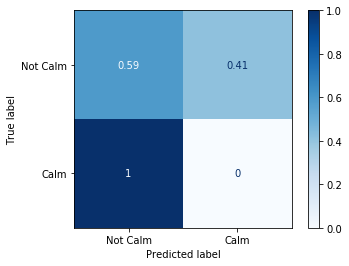

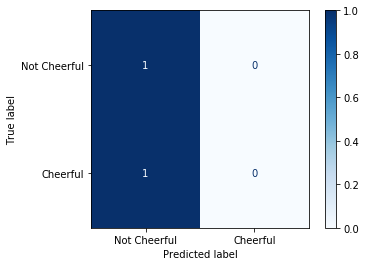

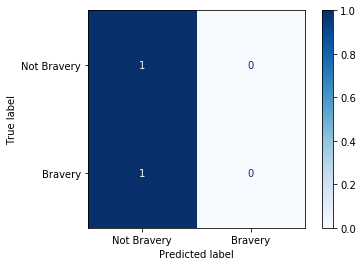

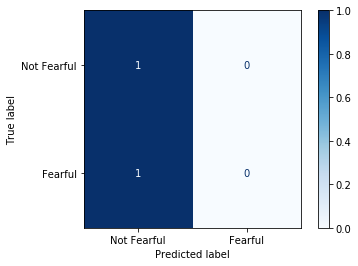

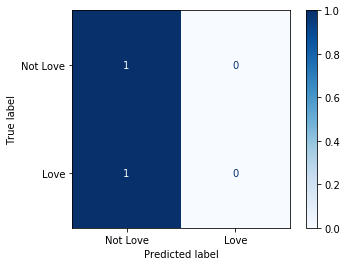

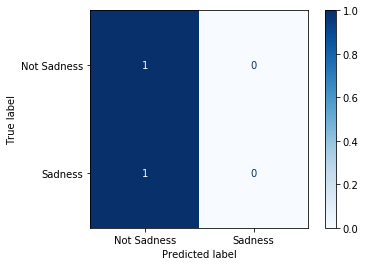

In [7]:
vanilla_rules = []
for i in range(0,6):
    if(i > 0):
        print()
        print()
    vanilla_rules = extract_ruleset(
        vanilla_rules,x_train,ovr_train[i],x_val,ovr_val[i],rscv,features,\
        themes,"Vanilla",itr_count=i
    )

In [8]:
vanilla_rules_sorted = []
for i in vanilla_rules:
    vanilla_rules_sorted.append(sorted(i, key = cmp_to_key(comp_func)))

In [9]:
classifiers = []
index = 0
for i in vanilla_rules_sorted:
    cls, acc = eval_rules(i, x_train, ovr_train[index]) 
    classifiers.append((cls, acc))
    index+=1
model = 0
vanilla_clsfs = []
for i in vanilla_rules_sorted:
    accuracy = classifiers[model][1]
    vanilla_clsfs.append(remove_unnecessary_rules(i, accuracy, x_train, ovr_train[model]))
    model+=1
model = 1
for mod in vanilla_clsfs:
    print("MODEL NUMBER ",model,":")
    num = 1
    for i in mod[0]:
        print("RULE NUMBER ", num,":")
        print(i[0])
        print("    error(s): ", i[1])
        num+=1
    print("TOTAL MATCHES: ",mod[1]/len(ovr_train[model-1])*100,"%") 
    print()
    model+=1

MODEL NUMBER  1 :
RULE NUMBER  1 :
 Derivative of Partial Based Spectral Centroid Overall Average <= 0.0800 ^  Derivative of Standard Deviation of Spectral Variability Overall Average <= 0.3300 ^  Running Mean of Spectral Rolloff Point Overall Average <= 0.1800 -> isCalm
    confidence: 0.41
    lift: 1.32
    interestingness: 5.50
    error(s):  92
RULE NUMBER  2 :
 Standard Deviation of Spectral Rolloff Point Overall Average > 0.2800 -> notCalm
    confidence: 0.17
    lift: 0.25
    interestingness: 1.79
    error(s):  0
TOTAL MATCHES:  100.0 %

MODEL NUMBER  2 :
RULE NUMBER  1 :
 -> notCheerful
    confidence: 0.86
    lift: 1.00
    interestingness: 18.60
    error(s):  0
TOTAL MATCHES:  100.0 %

MODEL NUMBER  3 :
RULE NUMBER  1 :
 -> notBravery
    confidence: 1.00
    lift: 1.16
    interestingness: 21.59
    error(s):  0
TOTAL MATCHES:  100.0 %

MODEL NUMBER  4 :
RULE NUMBER  1 :
 -> notFearful
    confidence: 1.00
    lift: 1.33
    interestingness: 23.07
    error(s):  0
TOTA

In [10]:
vanilla_val_mod = []
for mod in vanilla_clsfs:
    vmod = []
    for i in mod[0]:
        vmod.append(i[0])
    vanilla_val_mod.append(vmod)

In [11]:
index = 0
preds = []
for val in vanilla_val_mod:
    pred = predict_ovr(val, x_val, ovr_val[index], ovr_train[index])
    preds.append(pred)

In [12]:
ovr = ["isCalm","isCheerful","isBravery","isFearful","isLove","isSadness"]
for i in range(0, len(preds)):
    print(ovr[i], " ACCURACY:")
    compute_accuracy(preds[i], ovr_val[i])
    f1 = f1_score(ovr_val[i], preds[i])
    print("F1 SCORE: ", f1)
    print()

isCalm  ACCURACY:
0.47619047619047616
F1 SCORE:  0.0

isCheerful  ACCURACY:
0.8571428571428571
F1 SCORE:  0.0

isBravery  ACCURACY:
0.8095238095238095
F1 SCORE:  0.0

isFearful  ACCURACY:
0.8095238095238095
F1 SCORE:  0.0

isLove  ACCURACY:
0.8571428571428571
F1 SCORE:  0.0

isSadness  ACCURACY:
0.8571428571428571
F1 SCORE:  0.0



Best Score: 0.6340
Random Oversampling Train Accuracy: 79.7101%
[0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Random Oversampling Validation Accuracy: 57.14%
Random Oversampling F1-score: 0.59


Best Score: 0.7280
Random Oversampling Train Accuracy: 90.7514%
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Random Oversampling Validation Accuracy: 85.71%
Random Oversampling F1-score: 0.79


Best Score: 0.7841
Random Oversampling Train Accuracy: 91.3043%
[0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0]
[0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Random Oversampling Validation Accuracy: 57.14%
Random Oversampling F1-score: 0.61


Best Score: 0.5809
Random Oversampling Train Accuracy: 87.9139%
[0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0]
Random Oversampling Validation Accuracy: 71.43%
Random Oversampling F1-score: 0.71


Best Score: 0.8864
Random Oversampling Train Accurac

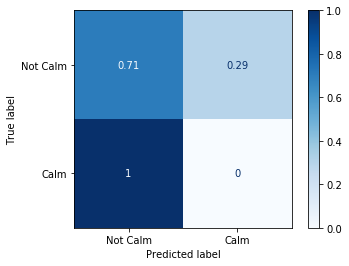

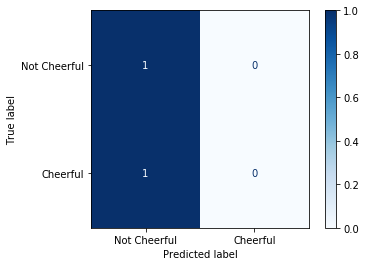

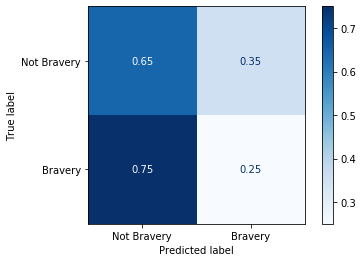

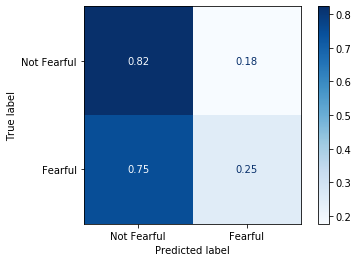

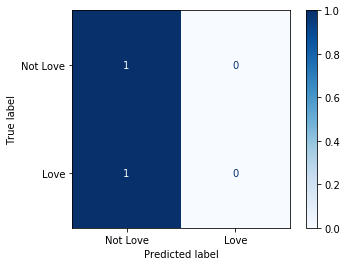

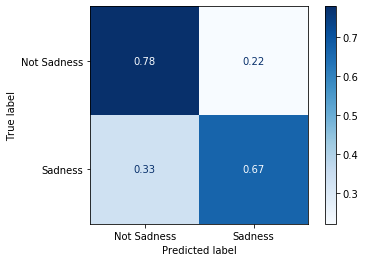

In [13]:
os_rules = []
for i in range(0,6):
    if(i > 0):
        print()
        print()
    os_rules = extract_ruleset(
        os_rules,x_oss[i],ovr_y_os[i],x_val,ovr_val[i],rscv,features,\
        themes,"Random Oversampling",itr_count=i
    )

In [14]:
os_rules_sorted = []
for i in os_rules:
    os_rules_sorted.append(sorted(i, key = cmp_to_key(comp_func)))

In [15]:
os_classifiers = []
index = 0
for i in os_rules_sorted:
    cls, acc = eval_rules(i, x_oss[index],ovr_y_os[index]) 
    os_classifiers.append((cls, acc))
    index+=1
model = 0
os_clsfs = []
for i in os_rules_sorted:
    accuracy = os_classifiers[model][1]
    os_clsfs.append(remove_unnecessary_rules(i, accuracy, x_oss[model],ovr_y_os[model]))
    model+=1
model = 1
for mod in os_clsfs:
    print("MODEL NUMBER ",model,":")
    num = 1
    for i in mod[0]:
        print("RULE NUMBER ", num,":")
        print(i[0])
        print("    error(s): ", i[1])
        num+=1
    print("TOTAL MATCHES: ",mod[1]/len(x_oss[model-1])*100,"%") 
    print()
    model+=1

MODEL NUMBER  1 :
RULE NUMBER  1 :
 Derivative of Spectral Variability Overall Standard Deviation > 0.2200 ^  Standard Deviation of Spectral Flux Overall Standard Deviation <= 0.1300 -> notCalm
    confidence: 0.11
    lift: 0.22
    interestingness: 0.94
    error(s):  244
RULE NUMBER  2 :
 Derivative of Running Mean of Beat Sum Overall Average <= 0.0400 ^  Standard Deviation of Spectral Rolloff Point Overall Average <= 0.1000 -> isCalm
    confidence: 0.00
    lift: 0.00
    interestingness: 0.00
    error(s):  0
TOTAL MATCHES:  100.0 %

MODEL NUMBER  2 :
RULE NUMBER  1 :
 Derivative of Standard Deviation of Fraction Of Low Energy Windows Overall Average > 0.5200 -> notCheerful
    confidence: 0.44
    lift: 0.87
    interestingness: 8.81
    error(s):  257
RULE NUMBER  2 :
 Standard Deviation of Spectral Flux Overall Average > 0.2400 ^  Derivative of Spectral Variability Overall Standard Deviation <= 0.2000 ^  Spectral Rolloff Point Overall Standard Deviation <= 0.1200 -> isCheerful

In [16]:
os_val_mod = []
for mod in os_clsfs:
    vmod = []
    for i in mod[0]:
        vmod.append(i[0])
    os_val_mod.append(vmod)

In [17]:
index = 0
preds = []
for val in os_val_mod:
    pred = predict_ovr(val, x_val, ovr_val[index], ovr_y_os[index])
    preds.append(pred)

In [18]:
ovr = ["isCalm","isCheerful","isBravery","isFearful","isLove","isSadness"]
for i in range(0, len(preds)):
    print(ovr[i], " Oversampling ACCURACY:")
    compute_accuracy(preds[i], ovr_val[i])
    f1 = f1_score(ovr_val[i], preds[i])
    print("F1 SCORE: ", f1)
    print()

isCalm  Oversampling ACCURACY:
0.7619047619047619
F1 SCORE:  0.0

isCheerful  Oversampling ACCURACY:
0.7142857142857143
F1 SCORE:  0.0

isBravery  Oversampling ACCURACY:
0.2857142857142857
F1 SCORE:  0.34782608695652173

isFearful  Oversampling ACCURACY:
0.8095238095238095
F1 SCORE:  0.0

isLove  Oversampling ACCURACY:
0.19047619047619047
F1 SCORE:  0.1904761904761905

isSadness  Oversampling ACCURACY:
0.6190476190476191
F1 SCORE:  0.2



Best Score: 0.6377
Random Oversampling Train Accuracy: 62.3188%
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Random Oversampling Validation Accuracy: 19.05%
Random Oversampling F1-score: 0.06


Best Score: 0.6820
Random Oversampling Train Accuracy: 76.0116%
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Random Oversampling Validation Accuracy: 90.48%
Random Oversampling F1-score: 0.88


Best Score: 0.6884
Random Oversampling Train Accuracy: 86.0870%
[0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1]
[0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Random Oversampling Validation Accuracy: 61.90%
Random Oversampling F1-score: 0.65


Best Score: 0.5923
Random Oversampling Train Accuracy: 70.0331%
[0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0]
Random Oversampling Validation Accuracy: 85.71%
Random Oversampling F1-score: 0.85


Best Score: 0.8676
Random Oversampling Train Accurac

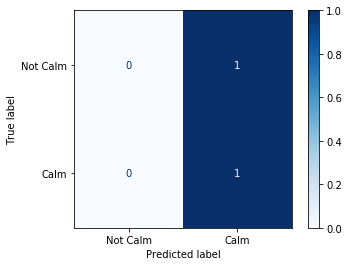

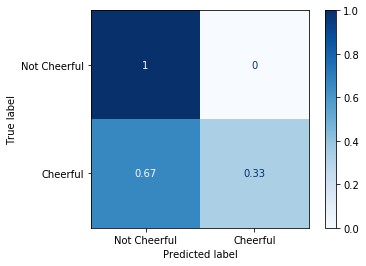

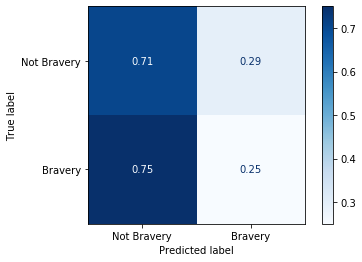

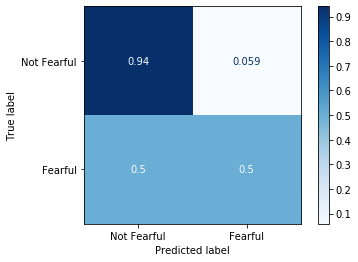

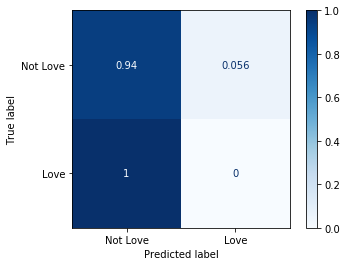

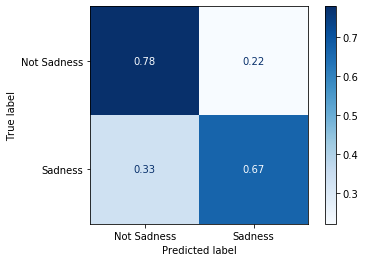

In [19]:
smote_rules = []
for i in range(0,6):
    if(i > 0):
        print()
        print()
    smote_rules = extract_ruleset(
        smote_rules,x_smotes[i],ovr_y_smote[i],x_val,ovr_val[i],rscv,features,\
        themes,"Random Oversampling",itr_count=i
    )

In [20]:
smote_rules_sorted = []
for i in smote_rules:
    smote_rules_sorted.append(sorted(i, key = cmp_to_key(comp_func)))

In [21]:
smote_classifiers = []
index = 0
for i in smote_rules_sorted:
    cls, acc = eval_rules(i, x_smotes[index],ovr_y_smote[index]) 
    smote_classifiers.append((cls, acc))
    index+=1
model = 0
smote_clsfs = []
for i in smote_rules_sorted:
    accuracy = smote_classifiers[model][1]
    smote_clsfs.append(remove_unnecessary_rules(i, accuracy,  x_smotes[model],ovr_y_smote[model]))
    model+=1
model = 1
for mod in smote_clsfs:
    print("MODEL NUMBER ",model,":")
    num = 1
    for i in mod[0]:
        print("RULE NUMBER ", num,":")
        print(i[0])
        print("    error(s): ", i[1])
        num+=1
    print("TOTAL MATCHES: ",mod[1]/len(x_smotes[model-1])*100,"%") 
    print()
    model+=1

MODEL NUMBER  1 :
RULE NUMBER  1 :
 Derivative of Partial Based Spectral Centroid Overall Average > 0.0800 -> notCalm
    confidence: 0.39
    lift: 0.78
    interestingness: 9.90
    error(s):  82
RULE NUMBER  2 :
 Derivative of Partial Based Spectral Centroid Overall Average <= 0.0800 -> isCalm
    confidence: 0.35
    lift: 1.55
    interestingness: 11.29
    error(s):  0
TOTAL MATCHES:  100.0 %

MODEL NUMBER  2 :
RULE NUMBER  1 :
 Derivative of Partial Based Spectral Flux Overall Standard Deviation > 0.1600 -> notCheerful
    confidence: 0.49
    lift: 0.98
    interestingness: 7.91
    error(s):  282
RULE NUMBER  2 :
 Derivative of Standard Deviation of Zero Crossings Overall Average > 0.6200 -> isCheerful
    confidence: 0.44
    lift: 5.60
    interestingness: 29.64
    error(s):  0
TOTAL MATCHES:  100.0 %

MODEL NUMBER  3 :
RULE NUMBER  1 :
 Derivative of MFCC Overall Standard Deviation <= 0.0400 ^  Standard Deviation of Spectral Centroid Overall Standard Deviation <= 0.0200 ^ 

In [22]:
smote_val_mod = []
for mod in smote_clsfs:
    vmod = []
    for i in mod[0]:
        vmod.append(i[0])
    smote_val_mod.append(vmod)

In [23]:
index = 0
preds = []
for val in smote_val_mod:
    pred = predict_ovr(val, x_val, ovr_val[index], ovr_y_smote[index])
    preds.append(pred)


In [24]:
ovr = ["isCalm","isCheerful","isBravery","isFearful","isLove","isSadness"]
for i in range(0, len(preds)):
    print(ovr[i], " SMOTE ACCURACY:")
    compute_accuracy(preds[i], ovr_val[i])
    f1 = f1_score(ovr_val[i], preds[i])
    print("F1 SCORE: ", f1)
    print()

isCalm  SMOTE ACCURACY:
0.19047619047619047
F1 SCORE:  0.32

isCheerful  SMOTE ACCURACY:
0.42857142857142855
F1 SCORE:  0.25

isBravery  SMOTE ACCURACY:
0.8095238095238095
F1 SCORE:  0.0

isFearful  SMOTE ACCURACY:
0.8095238095238095
F1 SCORE:  0.0

isLove  SMOTE ACCURACY:
0.23809523809523808
F1 SCORE:  0.2727272727272727

isSadness  SMOTE ACCURACY:
0.23809523809523808
F1 SCORE:  0.2727272727272727

